In [1]:
import os
import json
import glob

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

In [2]:
class Config:
    """config class with contains data, train and model hyperparameters"""


    def __init__(self):
        pass
    
    def from_json(self,json_path):
        """creates config from json"""
        params = json.load(open(json_path))
        # add to params path pathlib style 
        for k, v in params.items():
            print(k, v)
            setattr(self, k, v)
        return self
    
setting_file = "configs/config_v2.json"
Cfg = Config().from_json(setting_file)
os.makedirs(Cfg.preprocess_dir, exist_ok=True)
    

IS_DEBUG True
train_path dataloader/datasets/data_raw//train_series.parquet
train_target_path dataloader/datasets/data_raw/train_events.csv
test_path dataloader/datasets/data_raw/test_series.parquet
sample_submission_path dataloader/datasets/data_raw/sample_submission.csv
preprocess_dir dataloader/datasets/v2/
weight_dir_1dcnn model/weights_v2/
weight_dir_lgbm model/lgbm_models_v2/
inputs_2nd dataloader/datasets/v2/df_second_model.feather
steps_per_sec 0.2
step_for_1min 12.0
step_for_15min 180.0
step_for_30min 360.0
step_for_a_day 17280.0


In [3]:
df_train = pd.read_parquet(Cfg.train_path)
df_test = pd.read_parquet(Cfg.test_path)
sample_submission = pd.read_csv(Cfg.sample_submission_path)
df_target = pd.read_csv(Cfg.train_target_path)

In [4]:
df_target = pd.read_csv(Cfg.train_target_path)

In [5]:
series_id_list = df_target['series_id'].unique()
len(series_id_list)

277

In [6]:
series_id_list = df_target['series_id'].unique()
df_nans = pd.DataFrame()
for i in range(len(series_id_list)):
    data = {
        'series_id' : [series_id_list[i]],
        'nans_count' : [df_target[df_target["series_id"] == df_target['series_id'].unique()[i]]['step'].isnull().sum()]
    }
    df2 = pd.DataFrame(data)
    df_nans = pd.concat([df_nans,df2],ignore_index=True)
display(df_nans)

,series_id,nans_count
0,038441c925bb,8
1,03d92c9f6f8a,58
2,0402a003dae9,12
3,04f547b8017d,32
4,05e1944c3818,2
...,...,...
272,fa149c3c4bde,16
273,fb223ed2278c,96
274,fbf33b1a2c10,8
275,fcca183903b7,2


In [7]:
max_step = df_train.groupby("series_id")["step"].max().reset_index().rename(columns={"step": "step_max"})


In [8]:
df_train_target = pd.merge(df_target, max_step, on="series_id", how="left")
df_train_target.loc[df_train_target["step"].isnull(), "event"] = "nan"
df_train_target["step"] = df_train_target["step"].fillna(1)
df_train_target = df_train_target[df_train_target["step"] < df_train_target["step_max"]]
df_train_target = df_train_target[df_train_target["step"] > 0]
df_train_target

,series_id,night,event,step,timestamp,step_max
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400,389879
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400,389879
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400,389879
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400,389879
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400,389879
...,...,...,...,...,...,...
14503,fe90110788d2,33,wakeup,560604.0,2017-09-06T04:07:00-0400,592379
14504,fe90110788d2,34,onset,574620.0,2017-09-06T23:35:00-0400,592379
14505,fe90110788d2,34,wakeup,581604.0,2017-09-07T09:17:00-0400,592379
14506,fe90110788d2,35,nan,1.0,NaN,592379


In [9]:
target_count = df_train_target.groupby("series_id")["event"].count().reset_index()
display(target_count)

,series_id,event
0,038441c925bb,46
1,03d92c9f6f8a,74
2,0402a003dae9,48
3,04f547b8017d,74
4,05e1944c3818,16
...,...,...
272,fa149c3c4bde,48
273,fb223ed2278c,106
274,fbf33b1a2c10,48
275,fcca183903b7,72


In [10]:
df_train_target = pd.merge(max_step, target_count, on="series_id", how="left")
df_train_target["event"] = df_train_target["event"].fillna(0)
display(df_train_target)

,series_id,step_max,event
0,038441c925bb,389879,46
1,03d92c9f6f8a,724139,74
2,0402a003dae9,397259,48
3,04f547b8017d,637559,74
4,05e1944c3818,400859,16
...,...,...,...
272,fa149c3c4bde,406799,48
273,fb223ed2278c,918359,106
274,fbf33b1a2c10,421019,48
275,fcca183903b7,620639,72


Check if events per day is a linear curve

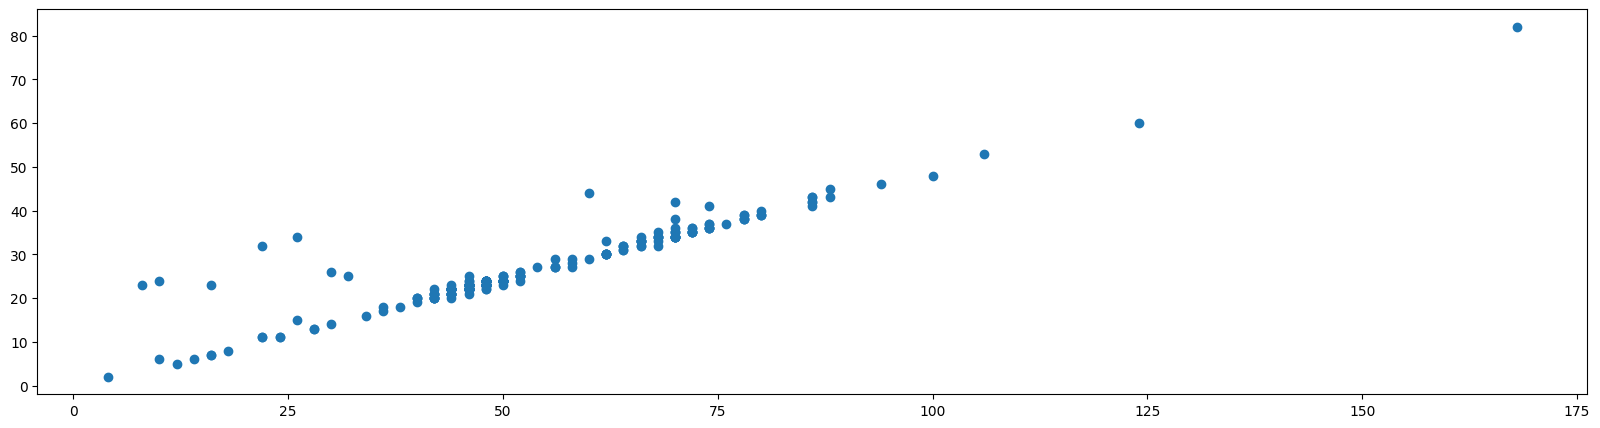

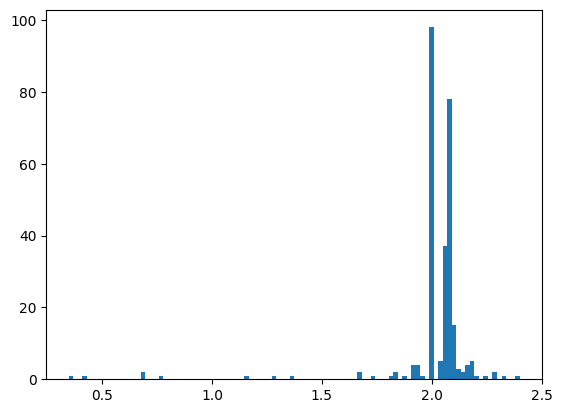

,series_id,step_max,event,days,ratio
0,038441c925bb,389879,46,22.0,2.090909
1,03d92c9f6f8a,724139,74,41.0,1.804878
2,0402a003dae9,397259,48,22.0,2.181818
3,04f547b8017d,637559,74,36.0,2.055556
4,05e1944c3818,400859,16,23.0,0.695652
...,...,...,...,...,...
272,fa149c3c4bde,406799,48,23.0,2.086957
273,fb223ed2278c,918359,106,53.0,2.000000
274,fbf33b1a2c10,421019,48,24.0,2.000000
275,fcca183903b7,620639,72,35.0,2.057143


In [11]:
df_train_target["days"] = df_train_target["step_max"] // Cfg.step_for_a_day
df_train_target["ratio"] = df_train_target["event"] / df_train_target["days"]
plt.figure(figsize=(20, 5))
plt.scatter(df_train_target["event"], df_train_target["days"])
plt.show()
plt.hist(df_train_target["ratio"], bins=100)
plt.show()

display(df_train_target)

Stratified K - Fold split generates indices to training / test with specific ratio, second parameter are target values

In [12]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=111)
for fold, (_, val_idx) in enumerate(skf.split(df_train_target, (df_train_target["ratio"].values//0.2).astype(int))):
    df_train_target.loc[val_idx, "fold"] = fold

df_train_target

d:\DEV\Projekty\PythonProjects\venv\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,series_id,step_max,event,days,ratio,fold
0,038441c925bb,389879,46,22.0,2.090909,3.0
1,03d92c9f6f8a,724139,74,41.0,1.804878,3.0
2,0402a003dae9,397259,48,22.0,2.181818,0.0
3,04f547b8017d,637559,74,36.0,2.055556,4.0
4,05e1944c3818,400859,16,23.0,0.695652,1.0
...,...,...,...,...,...,...
272,fa149c3c4bde,406799,48,23.0,2.086957,2.0
273,fb223ed2278c,918359,106,53.0,2.000000,1.0
274,fbf33b1a2c10,421019,48,24.0,2.000000,4.0
275,fcca183903b7,620639,72,35.0,2.057143,3.0


0   2018-08-14 15:30:00-04:00
dtype: datetime64[ns, UTC-04:00]
0    11160.0
dtype: float64


C:\Users\pawel.dubel\AppData\Local\Temp\ipykernel_27240\1760346496.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_train['dayofweek'] = (offset.dt.dayofweek.values[0] + (first_train['step'] + offset_step.values[0]) // Cfg.step_for_a_day) % 7
C:\Users\pawel.dubel\AppData\Local\Temp\ipykernel_27240\1760346496.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_train['daily_step'] = (first_train['step'] + offset_step.values[0]) % Cfg.step_for_a_day
C:\Users\pawel.dubel\AppData\Local\Temp\ipyk

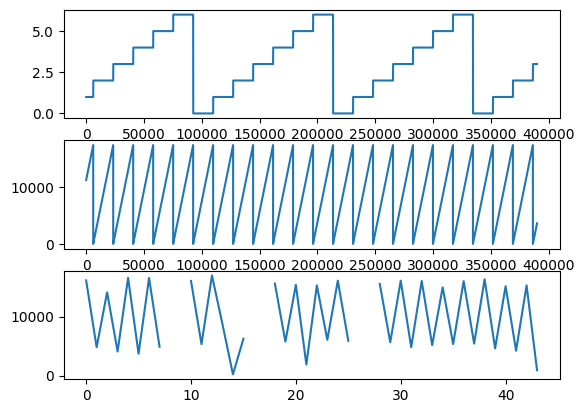

In [48]:

first_train = df_train[df_train["series_id"]==df_train.series_id[0]]
first_target = df_target[df_target["series_id"]==df_target.series_id[0]]

offset_date = df_train['timestamp'].iloc[0:1].str.split('T',expand=True)[0]
offset_time = df_train['timestamp'].iloc[0:1].str.split('T',expand=True)[1]
offset = pd.to_datetime(offset_date +" " + offset_time)
print(offset)
offset_step = (offset.dt.hour * 60 * 60 + offset.dt.minute * 60  + offset.dt.second) * Cfg.steps_per_sec
offset_step
print(offset_step)


first_train['dayofweek'] = (offset.dt.dayofweek.values[0] + (first_train['step'] + offset_step.values[0]) // Cfg.step_for_a_day) % 7
first_train['daily_step'] = (first_train['step'] + offset_step.values[0]) % Cfg.step_for_a_day
first_target['daily_step'] = (first_target['step'] + offset_step.values[0]) % Cfg.step_for_a_day

plt.subplot(3,1,1)
# plt.plot(((offset.dt.dayofweek.values[0] +  first_train['step'].astype(np.int32).map(lambda x : x+ int(offset_step.values[0]))// Cfg.step_for_a_day)) % 7)
plt.plot(first_train['dayofweek'])
plt.subplot(3,1,2)
plt.plot(first_train['daily_step'])
plt.subplot(3,1,3)
plt.plot(first_target['daily_step'])
plt.show()



In [60]:
first_target

,series_id,night,event,step,timestamp,daily_step
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400,16152.0
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400,4812.0
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400,14124.0
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400,4092.0
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400,16596.0
5,038441c925bb,3,wakeup,44400.0,2018-08-17T05:10:00-0400,3720.0
6,038441c925bb,4,onset,57240.0,2018-08-17T23:00:00-0400,16560.0
7,038441c925bb,4,wakeup,62856.0,2018-08-18T06:48:00-0400,4896.0
8,038441c925bb,5,onset,NaN,NaN,NaN
9,038441c925bb,5,wakeup,NaN,NaN,NaN


C:\Users\pawel.dubel\AppData\Local\Temp\ipykernel_27240\2961861222.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_train['target'] = -1
C:\Users\pawel.dubel\AppData\Local\Temp\ipykernel_27240\2961861222.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_train['target_sw'] = 0


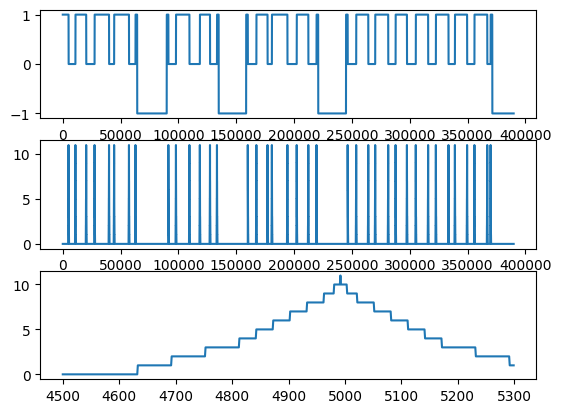

In [75]:
first_train['target'] = -1
first_train['target_sw'] = 0

sw_step_range = [i-1 for i in [1,12,30,60,90,120,150,180,240,300,360]][::-1]
sw_labels = [i for i in range(11,0,-1)][::-1]

last_state = -1
last_event_step = 0

valid_range_with_nan = int(Cfg.step_for_30min*4)
max_step = first_target['step'].values.max()

for step,event,night in first_target[["step","event","night"]].values:

    event_range = (first_train['step'] >= last_event_step) & (first_train['step'] <step)
    event_range_with_nan_before = (first_train['step'] >= np.maximum(step-valid_range_with_nan,0)) & (first_train['step'] <step)
    event_range_with_nan_after = (first_train['step'] < np.maximum(last_event_step+valid_range_with_nan,0)) & (first_train['step'] >= last_event_step)

    if np.isnan(step):
    
        first_train.loc[event_range_with_nan_after,'target'] = np.abs(last_event-1)
        last_state = -2
        continue

    if event =='onset' : 
        if last_state == 1 or last_state == -1:
            first_train.loc[event_range,'target'] = 1
        elif last_state == -2:
            first_train.loc[event_range_with_nan_before] = 1
        last_event = 1
        last_state = 0 
        last_event_step = step 
    
    elif event == 'wakeup':
        if last_state == 0 or last_state == -1:
            first_train.loc[event_range,'target'] = 0
        elif last_state == -2:
            first_train.loc[event_range_with_nan_before] = 0
        last_event = 0
        last_state = 1
        last_event_step = step 

    for label_range, sw_label in zip(sw_step_range, sw_labels):
        first_train.loc[(first_train['step'] >= (step - label_range)) & (first_train['step'] <= (step + label_range)), 'target_sw'] = sw_label


if last_state in range(0,2):
    end_step_for_train = last_event_step+valid_range_with_nan
else:
    end_step_for_train = (night - 1) * Cfg.step_for_a_day

plt.subplot(3,1,1)
plt.plot(first_train["target"])
plt.subplot(3,1,2)
plt.plot(first_train["target_sw"])
plt.subplot(3,1,3)
plt.plot(first_train['target_sw'][4500:5300])



In [80]:
def subplot_data(data):
    for i in range(len(data)):
        plt.subplot(len(data),1,i+1)
        plt.plot(data)
    plt.show()

In [81]:
def padding(x,left,right,value = 0):
    return np.pad(x,(left,right),'constant',constant_values=(value,value))

x = first_train['daily_step'].values
y = first_train['anglez'].values
mask = np.ones_like(y)
tar = first_train['target'].values * (first_train['target'].values > -1e-7)

subplot_data([x,y,mask,tar])



In [ ]:
def timestamp_to_step_single_id(df_train_id, df_target_id):
    """
    Convert timestamp to step
    timestepは2018-08-14T22:26:00-0400といった形で与えられる
    これを午前0時開始の経過時間に変換し、5秒ごとのstepに変換する
    idごとに処理する前提として、最初の時間をオフセットして、Cfg.daily_stepで割ってあまりをとる
    """
    # iloc[0]で最初の時間を取得
    offset_date = df_train_id['timestamp'].iloc[0:1].str.split('T', expand=True)[0]
    offset_time = df_train_id['timestamp'].iloc[0:1].str.split('T', expand=True)[1].str.split('-', expand=True)[0]
    offset = pd.to_datetime(offset_date + ' ' + offset_time)
    offset_step = offset.dt.hour * 60 * 12 + offset.dt.minute * 12 + offset.dt.second / 5
    df_train_id["daily_step"] = (df_train_id['step'] + offset_step.values[0]) % Cfg.step_for_a_day
    df_target_id["daily_step"] = (df_target_id['step'] + offset_step.values[0]) % Cfg.step_for_a_day
    df_train_id["dayofweek"] = ((offset.dt.dayofweek.values[0] +  df_train['step'].astype(np.int32).map(lambda x : x+ int(offset_step.values[0]))// Cfg.step_for_a_day)) % 7
    # print((df['step'].iloc[-1] + offset_step) % Cfg.step_for_a_day)
    return df_train_id, df_target_id


In [ ]:
train_columns = ['daily_step', 'anglez', 'anglez_simpleerror', 'anglez_simpleerror_span', 
'anglez_nanexist', 'anglez_daystd', 'anglez_daymean', "anglez_daycounter", "anglez_nancounter", 
'enmo', # "accz", "accaxay", # "step_count", "dayofweek", 
'target_sw', 'target']
# with timer(f"select_dataset {id_no}"):
#     df_train_id, df_target_id = sample_train_target_by_id(df_train, df_target, id_no)
with timer(f"timestamp_to_step {id_no}"):
    # df_train_id = timestamp_to_step(df_train_id)
    # df_target_id = timestamp_to_step(df_target_id)
    df_train_id, df_target_id = timestamp_to_step_single_id(df_train_id, df_target_id)
with timer(f"make_binary_target {id_no}"):
    # df_train_id, end_step_for_train = make_binary_target(df_train_id, df_target_id, id_no)
    df_train_id, end_step_for_train = make_multilabel_target(df_train_id, df_target_id, id_no)

with timer(f"find_sensor_error {id_no}"):
    df_train_id = find_sensor_error(df_train_id, column='anglez')
df_train_id = make_features(df_train_id)
df_train_id = prerprocess_inputs_for_mlmodel(df_train_id)
meta_data = {"end_step_for_train": end_step_for_train}


In [ ]:
for id_no, df_train_id in df_train.groupby('series_id'):
    print(id_no)
    df_target_id = df_target[df_target['series_id']==id_no]
    make_dataset(df_train_id, df_target_id, id_no)